# Nano-bigram forecasting

Using series data to predict an item 5 time steps ahead.

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.nn import functional as F
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Variables

from config import KEY, PERIOD, TARGET_PERIOD, STORE_PATH, SEQ_TYPE

In [3]:

# Build fp
fields = [KEY, str(PERIOD), str(TARGET_PERIOD), SEQ_TYPE]
DATA_FP = "_".join(fields)+".np"
VAL_DATA_FP = "_".join(fields+["val"])+".np"
MODEL_FP = "_".join(fields)+".pt"
fp = os.path.join(STORE_PATH, DATA_FP)
val_fp = os.path.join(STORE_PATH, VAL_DATA_FP)
model_fp = os.path.join(STORE_PATH, MODEL_FP)
val_fp

'C:/Users/robert.franklin/Desktop/local_projects/random/stock-gpt/stock_price_ingest/data/close_90_5_single_long_val.np'

In [4]:
# Import the data
data = np.load(fp)
val_data = np.load(val_fp)

In [5]:
data = np.where(np.isnan(data), 0, data)
val_data = np.where(np.isnan(val_data), 0, val_data)

In [6]:

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = PERIOD # what is the maximum context length for predictions?
max_epochs = 20000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
vocab_size = 1
# ------------

torch.manual_seed(1705)

In [7]:
# Train and test splits
train_data = torch.tensor(data, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.float32)
print("train and val data shape:", train_data.shape, val_data.shape)

train and val data shape: torch.Size([1034, 10941]) torch.Size([1034, 95])


In [8]:
# data loading
def norm_t(t: torch.Tensor) -> torch.Tensor:
    maxs = (
        torch.Tensor(
            np.nanmax(t.nan_to_num(posinf=torch.nan).numpy(), axis=-1)
        ) * torch.ones_like(t.T)).T
    mins = (
        torch.Tensor(
            np.nanmin(t.nan_to_num(posinf=torch.nan).numpy(), axis=-1)
        ) * torch.ones_like(t.T)).T
    return ((t - mins) / (maxs - mins))

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i, :block_size] for i in ix])
    y = torch.stack([data[i, 1:block_size+1] for i in ix])
    # data = train_data if split == 'train' else val_data
    # idx = torch.randperm(data.shape[0])
    # data = data[idx]
    # x = data[:, :block_size]
    # y = data[:, 1:block_size+1]
    # ix = torch.randint(len(data), (batch_size,))
    # x = x[ix,:]
    # y = y[ix,:]
    # Normalise
    x = norm_t(x)
    y = norm_t(y)
    # Convert inf to -1
    x = x.nan_to_num(neginf=-1, posinf=-1)
    y = y.nan_to_num(neginf=-1, posinf=-1)
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [9]:

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [10]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [11]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [12]:

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [20]:
class ForecastTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Linear(block_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # B == Batch
        # T == Input tensor length
        # C == Channels (positional embedding size)
        # idx and targets are both (B,T) tensor of integers
        print(idx.shape)
        print(idx)
        tok_emb = self.token_embedding_table(idx).unsqueeze(1) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device, dtype=torch.int64)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T)
            targets = targets.view(B*T)
            loss = F.mse_loss(logits, targets)

        return logits, loss, targets

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, _ = self(idx_cond)
            # append sampled index to the running sequence
            idx = torch.cat((idx, logits[:, :, -1][:, -1].unsqueeze(1)), dim=1) # (B, T+1)
        return idx

In [21]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta) \
            or np.isnan(validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:

model = ForecastTransformer()
m = model.to(device)
# print the number of parameters in the model
print(f"{sum(p.numel() for p in m.parameters()):,} parameters")

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
all_losses = []

# Loss estimation
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss, targets = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in tqdm(range(200), total=max_epochs, desc="Epoch"):

    # every once in a while evaluate the loss on train and val sets
    if epoch % eval_interval == 0 or epoch == max_epochs - 1:
        losses = estimate_loss()
        all_losses.append(losses)
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if early_stopper.early_stop(losses['val']):         
            print("Early stopping")
            break

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss, targets = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


210,945 parameters


Epoch:   0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([16, 90])
tensor([[0.2131, 0.1148, 0.0820,  ..., 0.0492, 0.0492, 0.0000],
        [0.0465, 0.0465, 0.0465,  ..., 0.6977, 0.7209, 0.6977],
        [0.2585, 0.2000, 0.2390,  ..., 0.7854, 0.7463, 0.7854],
        ...,
        [0.2042, 0.0737, 0.0316,  ..., 0.3726, 0.4337, 0.4211],
        [0.6769, 0.5538, 0.5538,  ..., 0.3231, 0.1846, 0.2769],
        [0.9940, 0.9612, 0.9066,  ..., 0.4821, 0.3661, 0.3519]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.9412, 0.9565, 0.9412,  ..., 0.0588, 0.0588, 0.0588],
        [0.7030, 0.6909, 0.7515,  ..., 0.7576, 0.7394, 0.7455],
        [0.4611, 0.5811, 0.5621,  ..., 0.6358, 0.6632, 0.6863],
        ...,
        [0.1143, 0.0908, 0.0551,  ..., 0.7925, 0.8533, 0.9157],
        [0.2653, 0.2041, 0.2449,  ..., 0.0153, 0.0000, 0.1122],
        [0.9060, 1.0000, 0.8389,  ..., 0.2819, 0.2215, 0.1879]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.3086, 0.4198, 0.4074,  ..., 0.4938, 0.4938, 0.4938],
        [0.1852, 0.2593, 0.22

Epoch:   0%|          | 1/20000 [00:00<1:49:50,  3.03it/s]

torch.Size([16, 90])
tensor([[ 0.2438,  0.3781,  0.4328,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0319,  0.0851,  0.0957,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0143,  0.0000,  0.2907,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 0.0125,  0.0000,  0.1625,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.0222,  0.1028,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0145,  0.0000,  0.0425,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[ 0.2891,  0.2534,  0.4249,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.9969,  1.0000,  0.9269,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.7897,  0.6612,  0.6495,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 0.0484,  0.0737,  0.1028,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.0309,  0.1237,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.1097,  0.0000,  0.1339,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[ 0.0000,  0.

Epoch:   0%|          | 8/20000 [00:00<18:01, 18.48it/s]  

torch.Size([16, 90])
tensor([[0.2247, 0.1685, 0.2360,  ..., 0.9213, 0.9326, 0.8764],
        [0.0638, 0.0000, 0.2289,  ..., 0.5159, 0.5447, 0.4968],
        [0.0000, 0.0000, 0.0000,  ..., 0.2935, 0.4027, 0.3809],
        ...,
        [0.4887, 0.4662, 0.4541,  ..., 0.6391, 0.5263, 0.6842],
        [0.5238, 0.5238, 0.5238,  ..., 0.9524, 0.9524, 0.9762],
        [0.5189, 0.7464, 0.8635,  ..., 0.3485, 0.2809, 0.3303]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4545, 0.4476, 0.4406,  ..., 0.9930, 1.0000, 0.9371],
        [0.0395, 0.0307, 0.0263,  ..., 0.9430, 0.9386, 0.9649],
        [0.4700, 0.4400, 0.4500,  ..., 0.1500, 0.1900, 0.2700],
        ...,
        [0.0041, 0.1250, 0.1250,  ..., 0.5998, 0.6961, 0.8291],
        [0.0000, 0.0667, 0.1667,  ..., 0.5333, 0.5333, 0.5333],
        [0.3581, 0.3581, 0.3150,  ..., 0.9115, 1.0000, 0.8824]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.9271, 0.9125, 0.9913,  ..., 0.0583, 0.0292, 0.0000],
        [0.0000, 0.0000, 0.00

Epoch:   0%|          | 13/20000 [00:00<12:50, 25.93it/s]

tensor([[0.6860, 0.7907, 0.8488,  ..., 0.7209, 0.6512, 0.6512],
        [0.0000, 0.2577, 0.2872,  ..., 0.9043, 0.9558, 0.9705],
        [0.9222, 0.7333, 0.7333,  ..., 0.0333, 0.0333, 0.0222],
        ...,
        [0.0000, 0.3684, 0.3947,  ..., 0.7632, 0.8947, 0.8947],
        [0.0000, 0.0000, 0.1111,  ..., 0.5556, 0.5556, 0.5556],
        [0.0000, 0.1596, 0.2607,  ..., 0.5964, 0.6427, 0.6567]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0741, 0.0741, 0.0700,  ..., 0.9588, 0.9671, 0.9753],
        [0.3638, 0.3315, 0.3394,  ..., 0.7724, 0.8748, 0.8732],
        [0.0864, 0.0930, 0.0631,  ..., 1.0000, 0.9934, 0.9801],
        ...,
        [0.2889, 0.2889, 0.2889,  ..., 0.7778, 0.8444, 0.8444],
        [0.4865, 0.4054, 0.4054,  ..., 0.7297, 0.8649, 0.9189],
        [0.0000, 0.0132, 0.1083,  ..., 1.0000, 0.9762, 0.9300]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0714, 0.0612, 0.0306,  ..., 0.7959, 0.7959, 0.8469],
        [0.0000, 0.0488, 0.0427,  ..., 1.0000, 0.9

Epoch:   0%|          | 23/20000 [00:00<09:44, 34.19it/s]

tensor([[0.0659, 0.0659, 0.0659,  ..., 0.7253, 0.7912, 1.0000],
        [0.2222, 0.3333, 0.3889,  ..., 0.3889, 0.4167, 0.4167],
        [0.8148, 0.8148, 0.8148,  ..., 0.0741, 0.0741, 0.0741],
        ...,
        [0.0000, 0.2871, 0.2392,  ..., 0.7608, 0.7608, 0.7952],
        [0.2326, 0.2558, 0.2698,  ..., 0.9674, 0.9674, 1.0000],
        [0.8268, 0.8030, 0.7814,  ..., 0.4805, 0.5368, 0.6234]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0999, 0.0853, 0.1242,  ..., 0.7852, 0.9481, 0.8839],
        [0.2013, 0.2338, 0.2792,  ..., 0.9221, 0.9026, 0.9416],
        [0.0870, 0.0000, 0.0145,  ..., 0.9420, 1.0000, 1.0000],
        ...,
        [0.1111, 0.1778, 0.3556,  ..., 0.9333, 0.9111, 0.9333],
        [0.1935, 0.1613, 0.1613,  ..., 0.9355, 1.0000, 0.9032],
        [0.7039, 0.5579, 0.4206,  ..., 0.8584, 0.9185, 0.8755]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.9255, 0.8938, 0.8509,  ..., 0.2259, 0.2206, 0.2658],
        [0.0099, 0.0149, 0.0049,  ..., 0.9938, 0.9

Epoch:   0%|          | 32/20000 [00:01<08:54, 37.37it/s]

tensor([[0.1897, 0.1034, 0.0086,  ..., 0.6293, 0.6810, 0.5776],
        [0.3235, 0.2941, 0.3235,  ..., 1.0000, 0.9779, 1.0000],
        [0.3084, 0.3318, 0.3551,  ..., 0.7150, 0.9673, 0.8785],
        ...,
        [0.2288, 0.1307, 0.0000,  ..., 0.3235, 0.3987, 0.2549],
        [0.2104, 0.2715, 0.2828,  ..., 0.3077, 0.3869, 0.4457],
        [0.6820, 0.6996, 0.7173,  ..., 0.7809, 0.9929, 0.9717]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0119, 0.0417, 0.0545,  ..., 0.9310, 1.0000, 0.9940],
        [0.1429, 0.1429, 0.1429,  ..., 0.6429, 0.6429, 0.6429],
        [0.5882, 0.4706, 0.4706,  ..., 0.4706, 0.3529, 0.3529],
        ...,
        [0.2590, 0.2347, 0.2000,  ..., 0.0231, 0.0231, 0.0231],
        [0.0682, 0.1023, 0.0227,  ..., 0.3864, 0.6818, 0.7727],
        [0.0745, 0.0000, 0.1145,  ..., 0.8391, 0.8683, 0.8618]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4313, 0.2405, 0.3626,  ..., 0.8893, 0.9313, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.8065, 0.9

Epoch:   0%|          | 37/20000 [00:01<08:29, 39.21it/s]

tensor([[1.0000, 0.8800, 0.9600,  ..., 0.0000, 0.0000, 0.0400],
        [0.9349, 0.9542, 0.9378,  ..., 0.0626, 0.0106, 0.0294],
        [0.1316, 0.1228, 0.1053,  ..., 0.9737, 0.9825, 1.0000],
        ...,
        [1.0000, 0.9231, 0.9231,  ..., 1.0000, 1.0000, 1.0000],
        [0.1429, 0.0714, 0.0714,  ..., 1.0000, 1.0000, 1.0000],
        [0.5195, 0.4656, 0.5625,  ..., 0.3359, 0.3125, 0.5156]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0659, 0.0659, 0.0659,  ..., 0.7253, 0.7912, 1.0000],
        [1.0000, 0.9280, 0.7520,  ..., 0.4960, 0.5600, 0.5040],
        [0.6166, 0.7383, 0.6943,  ..., 0.2772, 0.3549, 0.4430],
        ...,
        [0.1111, 0.0926, 0.0926,  ..., 0.9907, 0.9907, 0.9907],
        [0.4379, 0.4778, 0.6511,  ..., 0.6440, 0.6511, 0.6534],
        [0.1111, 0.1778, 0.3556,  ..., 0.9333, 0.9111, 0.9333]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0470, 0.0302,  ..., 0.8792, 0.8993, 1.0000],
        [0.3465, 0.5700, 0.5365,  ..., 0.8204, 0.8

Epoch:   0%|          | 47/20000 [00:01<08:19, 39.95it/s]

tensor([[1.0000, 0.7951, 0.6473,  ..., 0.2502, 0.1493, 0.1244],
        [0.2143, 0.2143, 0.1190,  ..., 0.1905, 0.3333, 0.3809],
        [0.8383, 0.9756, 0.9981,  ..., 0.5977, 0.5357, 0.0000],
        ...,
        [0.1159, 0.0145, 0.0435,  ..., 0.3913, 0.4493, 0.4203],
        [0.0999, 0.0853, 0.1242,  ..., 0.7852, 0.9481, 0.8839],
        [0.6166, 0.7383, 0.6943,  ..., 0.2772, 0.3549, 0.4430]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0041, 0.1250, 0.1250,  ..., 0.5998, 0.6961, 0.8291],
        [1.0000, 0.9615, 0.9231,  ..., 0.8077, 0.8462, 0.8462],
        [0.2048, 0.1687, 0.1205,  ..., 0.8916, 0.9639, 0.8554],
        ...,
        [0.9222, 0.7333, 0.7333,  ..., 0.0333, 0.0333, 0.0222],
        [0.4611, 0.5811, 0.5621,  ..., 0.6358, 0.6632, 0.6863],
        [0.4493, 0.3919, 0.3296,  ..., 0.0000, 0.0164, 0.0655]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[ 0.4545,  0.4476,  0.4406,  ...,  0.9930,  1.0000,  0.9371],
        [ 0.0161,  0.0115,  0.0023,  ...,  0

Epoch:   0%|          | 57/20000 [00:01<08:11, 40.54it/s]

tensor([[0.7759, 0.9063, 0.9470,  ..., 0.6292, 0.6007, 0.6516],
        [0.1266, 0.0949, 0.1076,  ..., 0.4114, 0.3861, 0.3797],
        [0.2153, 0.2522, 0.2581,  ..., 0.6917, 0.7286, 0.5457],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8293, 0.8293, 0.8293],
        [0.1263, 0.1935, 0.0511,  ..., 0.9597, 0.8387, 0.8118],
        [0.7115, 0.8462, 0.8654,  ..., 0.0769, 0.0769, 0.0962]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0340, 0.0717,  ..., 0.9849, 0.9774, 0.9849],
        [0.0000, 0.0504, 0.0543,  ..., 0.9612, 0.9225, 0.9419],
        [0.2013, 0.2338, 0.2792,  ..., 0.9221, 0.9026, 0.9416],
        ...,
        [0.1667, 0.1667, 0.5000,  ..., 0.7222, 0.7222, 0.6667],
        [0.0254, 0.0485, 0.0000,  ..., 0.5335, 0.5335, 0.3880],
        [0.0222, 0.1154, 0.0675,  ..., 0.7657, 1.0000, 0.9642]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4614, 0.4512, 0.4207,  ..., 0.4817, 0.4370, 0.5224],
        [0.2963, 0.4815, 0.4815,  ..., 0.2593, 0.2

Epoch:   0%|          | 62/20000 [00:01<07:53, 42.12it/s]

torch.Size([16, 90])
tensor([[0.2500, 0.2500, 0.2321,  ..., 0.9732, 1.0000, 1.0000],
        [0.0127, 0.0000, 0.0380,  ..., 0.0506, 0.1013, 0.1139],
        [0.4658, 0.5959, 0.6233,  ..., 0.9315, 0.9726, 0.8767],
        ...,
        [0.2000, 0.2000, 0.2000,  ..., 0.8000, 0.8000, 0.8000],
        [0.6040, 0.5235, 0.4899,  ..., 0.7517, 0.7584, 0.8121],
        [0.8491, 0.7358, 0.8679,  ..., 0.6038, 0.6981, 0.8113]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.7521, 0.7798, 0.8513,  ..., 0.0824, 0.0613, 0.0000],
        [1.0000, 0.8852, 0.9344,  ..., 0.1803, 0.1311, 0.1475],
        [0.2163, 0.1570, 0.0565,  ..., 0.5409, 0.4864, 0.4593],
        ...,
        [0.6144, 0.5799, 0.5411,  ..., 0.4384, 0.4677, 0.4018],
        [0.1000, 0.0000, 0.0600,  ..., 0.5400, 0.5800, 0.6200],
        [0.5667, 0.4500, 0.3167,  ..., 0.3667, 0.2667, 0.2500]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.3705, 0.3851, 0.3275,  ..., 0.8986, 0.7484, 0.7279],
        [0.2810, 0.2562, 0.29

Epoch:   0%|          | 72/20000 [00:02<08:05, 41.06it/s]

tensor([[0.2000, 0.5667, 0.6000,  ..., 0.9667, 0.8000, 0.9333],
        [0.3929, 0.3571, 0.4286,  ..., 0.9643, 0.9286, 0.9286],
        [0.7577, 0.6872, 0.7401,  ..., 0.9229, 0.9251, 0.9449],
        ...,
        [1.0000, 0.9828, 0.8793,  ..., 0.3793, 0.4310, 0.4397],
        [0.6096, 0.6264, 0.6264,  ..., 0.0337, 0.0337, 0.0337],
        [0.1852, 0.0834, 0.0771,  ..., 0.8962, 0.9636, 0.9318]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.1316, 0.1228, 0.1053,  ..., 0.9737, 0.9825, 1.0000],
        [0.0000, 0.0243, 0.0405,  ..., 1.0000, 0.9595, 0.9514],
        [0.2000, 0.5667, 0.6000,  ..., 0.9667, 0.8000, 0.9333],
        ...,
        [0.4000, 0.4857, 0.4286,  ..., 0.7600, 0.7829, 0.7829],
        [0.9856, 0.9856, 0.9856,  ..., 0.0108, 0.0542, 0.0181],
        [0.2632, 0.2895, 0.4737,  ..., 0.4474, 0.3947, 0.5000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.1429, 0.2009,  ..., 0.6875, 0.6875, 0.6875],
        [0.0047, 0.0047, 0.0000,  ..., 0.4597, 0.5

Epoch:   0%|          | 77/20000 [00:02<07:55, 41.92it/s]

tensor([[0.6667, 0.6190, 0.6190,  ..., 0.9048, 0.9048, 1.0000],
        [0.0000, 0.0284, 0.0341,  ..., 1.0000, 1.0000, 0.9205],
        [0.3861, 0.3861, 0.3366,  ..., 0.4059, 0.4059, 0.3069],
        ...,
        [0.1111, 0.0926, 0.0926,  ..., 0.9907, 0.9907, 0.9907],
        [0.6667, 0.6154, 0.5385,  ..., 0.6154, 0.6410, 0.6154],
        [0.9412, 0.9565, 0.9412,  ..., 0.0588, 0.0588, 0.0588]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4667, 0.4333, 0.4333,  ..., 0.2000, 0.2000, 0.2000],
        [0.3030, 0.2879, 0.2727,  ..., 0.9091, 0.9545, 1.0000],
        [0.7727, 0.7045, 0.7727,  ..., 0.8864, 0.8864, 0.9091],
        ...,
        [0.7222, 0.6444, 0.5778,  ..., 0.2556, 0.2556, 0.2778],
        [0.6200, 0.6600, 0.5600,  ..., 0.3400, 0.3400, 0.3600],
        [0.1210, 0.0806, 0.1935,  ..., 0.9516, 1.0000, 0.9758]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.8462, 0.7308, 0.6538,  ..., 0.5000, 0.5192, 0.4615],
        [0.0000, 0.0392, 0.0980,  ..., 0.8824, 0.8

Epoch:   0%|          | 87/20000 [00:02<07:51, 42.25it/s]

tensor([[0.0000, 0.0289, 0.0496,  ..., 0.9132, 0.8182, 0.8574],
        [0.3051, 0.3390, 0.3051,  ..., 0.3898, 0.4068, 0.4322],
        [0.9318, 0.8864, 0.9545,  ..., 0.5341, 0.3636, 0.1193],
        ...,
        [0.0041, 0.1250, 0.1250,  ..., 0.5998, 0.6961, 0.8291],
        [0.3530, 0.4177, 0.3853,  ..., 0.6068, 0.6263, 0.7046],
        [0.0000, 0.1000, 0.1000,  ..., 0.6000, 0.5667, 0.5667]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0829, 0.0507,  ..., 0.8203, 0.9585, 1.0000],
        [0.0000, 0.0000, 0.0816,  ..., 0.6939, 0.5918, 0.5816],
        [0.0000, 0.0000, 0.0000,  ..., 0.8333, 0.8333, 0.8333],
        ...,
        [0.0333, 0.0188, 0.0000,  ..., 0.8144, 0.8389, 0.8822],
        [0.2889, 0.2889, 0.2889,  ..., 0.7778, 0.8444, 0.8444],
        [0.2042, 0.0737, 0.0316,  ..., 0.3726, 0.4337, 0.4211]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.9795, 0.9795, 1.0000],
        [0.2244, 0.2012, 0.1488,  ..., 0.0622, 0.1

Epoch:   0%|          | 92/20000 [00:02<07:51, 42.21it/s]

tensor([[0.0000, 0.3446, 0.4616,  ..., 0.8596, 0.8361, 0.8596],
        [0.8140, 0.8256, 0.7093,  ..., 0.1163, 0.1163, 0.1512],
        [0.0517, 0.0619, 0.0944,  ..., 0.5135, 0.5538, 0.4516],
        ...,
        [0.3476, 0.0820, 0.1266,  ..., 0.0624, 0.3137, 0.3494],
        [0.0867, 0.1429, 0.2272,  ..., 1.0000, 0.8923, 0.8548],
        [0.2000, 0.2500, 0.2000,  ..., 0.7500, 0.8000, 0.7500]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[1.0000, 0.3276, 1.0000,  ..., 0.7069, 0.6552, 0.6552],
        [0.6006, 0.5866, 0.6145,  ..., 0.4609, 0.5419, 0.5056],
        [0.0931, 0.0931, 0.0955,  ..., 0.7613, 1.0000, 0.9609],
        ...,
        [1.0000, 0.7895, 0.7895,  ..., 0.6316, 0.4211, 0.4211],
        [0.8391, 0.8233, 0.7981,  ..., 0.8281, 0.8659, 1.0000],
        [0.6264, 0.6910, 0.7865,  ..., 0.2079, 0.0281, 0.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.2703, 0.2703, 0.2973,  ..., 1.0000, 1.0000, 1.0000],
        [0.8864, 0.8182, 0.8409,  ..., 0.8409, 0.8

Epoch:   0%|          | 97/20000 [00:02<07:43, 42.91it/s]

torch.Size([16, 90])
tensor([[0.3636, 0.3295, 0.3068,  ..., 0.9545, 0.9545, 0.9545],
        [0.5600, 0.5600, 0.6400,  ..., 0.7200, 0.8800, 1.0000],
        [0.1620, 0.0634, 0.0423,  ..., 0.6197, 0.6479, 0.7324],
        ...,
        [0.3830, 0.4149, 0.4255,  ..., 0.4149, 0.4149, 0.4043],
        [0.1248, 0.1155, 0.1465,  ..., 0.8005, 0.7617, 0.7783],
        [0.2104, 0.2715, 0.2828,  ..., 0.3077, 0.3869, 0.4457]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.1812, 0.1074, 0.1007,  ..., 0.6107, 0.8221, 1.0000],
        [0.2903, 0.2903, 0.2903,  ..., 0.8548, 0.8387, 0.8065],
        [0.0909, 0.0000, 0.0273,  ..., 0.9091, 0.9091, 1.0000],
        ...,
        [0.6724, 0.6552, 0.6379,  ..., 0.8966, 0.9138, 0.9655],
        [0.0000, 0.0000, 0.0538,  ..., 0.9570, 0.9570, 1.0000],
        [0.9194, 0.7742, 0.7258,  ..., 0.9194, 0.9194, 0.9194]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.5366, 0.5366, 0.5366,  ..., 0.8293, 0.7561, 0.8488],
        [0.7143, 0.8929, 0.89

Epoch:   1%|          | 107/20000 [00:03<10:03, 32.97it/s]

tensor([[ 0.3560,  0.3952,  0.4864,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.0706,  0.1167,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.2234,  0.1702,  0.2128,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 1.0000,  0.9352,  0.9907,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.8485,  0.8753,  0.1119,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.0000,  0.2353,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[ 0.0333,  0.0333,  0.0500,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.3750,  0.3861,  0.4944,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.3737,  0.2747,  0.3232,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 0.7506,  0.8315,  0.8260,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.1387,  0.1871,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.2083,  0.2083,  0.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[ 0.0000,  0.0250,  0.1238,  ..., 

Epoch:   1%|          | 112/20000 [00:03<09:04, 36.51it/s]

torch.Size([16, 90])
tensor([[ 0.8824,  0.8824,  0.8039,  ...,  0.8039,  0.9510,  1.0000],
        [ 0.1812,  0.1074,  0.1007,  ...,  0.6107,  0.8221,  1.0000],
        [ 0.0417,  0.1667,  0.0833,  ...,  0.8750,  0.8125,  0.7500],
        ...,
        [ 0.0000,  0.0470,  0.0302,  ...,  0.8792,  0.8993,  1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  0.5969,  0.5822],
        [ 0.5667,  0.4500,  0.3167,  ...,  0.3667,  0.2667,  0.2500]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.2632, 0.2895, 0.4737,  ..., 0.4474, 0.3947, 0.5000],
        [0.0000, 0.0500, 0.0659,  ..., 0.6864, 0.6136, 0.6886],
        [0.0856, 0.1658, 0.0802,  ..., 0.9572, 1.0000, 0.9813],
        ...,
        [0.7829, 0.4651, 0.7132,  ..., 0.2171, 0.2946, 0.3488],
        [0.9205, 0.9744, 1.0000,  ..., 0.1538, 0.1795, 0.1154],
        [0.3530, 0.4177, 0.3853,  ..., 0.6068, 0.6263, 0.7046]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.7284, 0.7531, 0.8333,  ..., 0.1111, 0.1852, 0.

Epoch:   1%|          | 122/20000 [00:03<08:19, 39.82it/s]

tensor([[0.1248, 0.1155, 0.1465,  ..., 0.8005, 0.7617, 0.7783],
        [0.7703, 0.7027, 0.6892,  ..., 0.9324, 0.8784, 0.9189],
        [0.3086, 0.4198, 0.4074,  ..., 0.4938, 0.4938, 0.4938],
        ...,
        [0.9333, 1.0000, 0.9714,  ..., 0.1048, 0.1048, 0.1048],
        [0.1017, 0.0000, 0.0000,  ..., 0.8305, 0.8644, 0.9797],
        [0.8286, 0.7571, 0.7429,  ..., 0.8286, 0.8000, 0.8000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.1893, 0.1562, 0.1538,  ..., 0.9586, 0.9941, 1.0000],
        [0.0000, 0.0132, 0.1083,  ..., 1.0000, 0.9762, 0.9300],
        [0.1795, 0.2051, 0.1795,  ..., 0.8718, 0.8718, 0.8718],
        ...,
        [0.5238, 0.5238, 0.5238,  ..., 0.9524, 0.9524, 0.9762],
        [0.3086, 0.4198, 0.4074,  ..., 0.4938, 0.4938, 0.4938],
        [0.0376, 0.0000, 0.0211,  ..., 0.9421, 1.0000, 0.9729]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.1629, 0.1407, 0.1555,  ..., 0.9271, 0.8867, 0.9190],
        [0.0000, 0.1114, 0.1114,  ..., 0.8709, 0.8

Epoch:   1%|          | 127/20000 [00:03<08:26, 39.21it/s]

tensor([[0.1667, 0.2143, 0.1190,  ..., 0.3571, 0.3571, 0.3810],
        [0.0000, 0.0667, 0.1667,  ..., 0.6478, 0.6444, 0.4500],
        [1.0000, 0.9333, 0.8571,  ..., 0.2190, 0.2571, 0.2381],
        ...,
        [1.0000, 0.7951, 0.6473,  ..., 0.2502, 0.1493, 0.1244],
        [0.0000, 0.0344, 0.0279,  ..., 0.9806, 0.9968, 1.0000],
        [0.2111, 0.2889, 0.3222,  ..., 0.7333, 0.6889, 0.5444]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0469, 0.1250,  ..., 1.0000, 0.9531, 0.9531],
        [0.8462, 0.7308, 0.6538,  ..., 0.5000, 0.5192, 0.4615],
        [0.1667, 0.0833, 0.0417,  ..., 0.9167, 0.9167, 0.7917],
        ...,
        [0.3000, 0.2500, 0.3375,  ..., 1.0000, 1.0000, 1.0000],
        [0.8992, 0.4710, 0.1839,  ..., 0.2443, 0.2192, 0.1940],
        [0.3704, 0.3704, 0.3704,  ..., 0.4074, 0.4074, 0.5185]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4667, 0.4333, 0.4333,  ..., 0.2000, 0.2000, 0.2000],
        [0.1111, 0.0926, 0.0926,  ..., 0.9907, 0.9

Epoch:   1%|          | 137/20000 [00:03<08:09, 40.58it/s]

tensor([[1.0000, 0.9231, 0.9231,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9398, 0.8496,  ..., 0.1654, 0.1429, 0.1654],
        [0.0271, 0.0000, 0.1461,  ..., 0.9091, 0.9535, 0.9481],
        ...,
        [1.0000, 1.0000, 0.9556,  ..., 0.4889, 0.4889, 0.4444],
        [1.0000, 0.7895, 0.7895,  ..., 0.6316, 0.4211, 0.4211],
        [0.8108, 0.7703, 0.6892,  ..., 0.8649, 0.8108, 0.7838]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4138, 0.3103, 0.4828,  ..., 0.9655, 0.9310, 0.9655],
        [0.7717, 0.8031, 0.7992,  ..., 0.5827, 0.6063, 0.5433],
        [0.4756, 0.3232, 0.2744,  ..., 0.2378, 0.2256, 0.2439],
        ...,
        [0.1812, 0.1074, 0.1007,  ..., 0.6107, 0.8221, 1.0000],
        [0.0275, 0.0436, 0.0917,  ..., 1.0000, 0.9541, 0.9908],
        [0.1068, 0.0340, 0.0000,  ..., 0.6165, 0.6796, 0.6893]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0669, 0.0578, 0.0701,  ..., 0.9057, 0.8488, 0.8206],
        [0.0000, 0.0500, 0.0167,  ..., 0.8167, 0.7

Epoch:   1%|          | 147/20000 [00:04<07:53, 41.90it/s]

torch.Size([16, 90])
tensor([[0.4014, 0.3099, 0.2817,  ..., 0.3803, 0.3451, 0.3099],
        [0.0000, 0.3333, 0.4667,  ..., 1.0000, 0.9333, 0.9333],
        [0.1434, 0.1319, 0.2084,  ..., 1.0000, 0.9369, 0.8891],
        ...,
        [0.0000, 0.3750, 0.1719,  ..., 0.3719, 0.3906, 0.3594],
        [0.5130, 0.5130, 0.4696,  ..., 0.2696, 0.3391, 0.2261],
        [0.0000, 0.0143, 0.0214,  ..., 1.0000, 0.9857, 0.9929]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[1.0000, 1.0000, 0.6792,  ..., 0.5660, 0.5283, 0.5283],
        [0.4555, 0.4031, 0.4921,  ..., 0.3194, 0.2461, 0.2356],
        [0.7115, 0.8462, 0.8654,  ..., 0.0769, 0.0769, 0.0962],
        ...,
        [0.4491, 0.7288, 0.5000,  ..., 0.0678, 0.0932, 0.1017],
        [0.0000, 0.0000, 0.0000,  ..., 0.8333, 0.8333, 0.8333],
        [0.1812, 0.1074, 0.1007,  ..., 0.6107, 0.8221, 1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.2719, 0.2807, 0.2544,  ..., 0.7105, 0.7018, 0.7632],
        [0.3711, 0.3608, 0.23

Epoch:   1%|          | 152/20000 [00:04<07:50, 42.18it/s]

tensor([[0.2889, 0.2889, 0.2889,  ..., 0.7778, 0.8444, 0.8444],
        [0.8283, 0.5452, 0.4819,  ..., 0.1958, 0.1747, 0.2711],
        [0.7352, 0.6904, 0.6415,  ..., 0.5214, 0.4623, 0.5295],
        ...,
        [0.1316, 0.1228, 0.1053,  ..., 0.9737, 0.9825, 1.0000],
        [0.2632, 0.2895, 0.4737,  ..., 0.4474, 0.3947, 0.5000],
        [0.0000, 0.3684, 0.3947,  ..., 0.7632, 0.8947, 0.8947]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.6179, 0.6087, 0.4136,  ..., 0.6179, 0.5701, 0.6067],
        [0.2585, 0.2000, 0.2390,  ..., 0.7854, 0.7463, 0.7854],
        [0.0170, 0.0150, 0.0163,  ..., 1.0000, 0.9667, 0.7520],
        ...,
        [1.0000, 0.9854, 0.8394,  ..., 0.1372, 0.0949, 0.0000],
        [0.5000, 0.5278, 0.5000,  ..., 0.8889, 0.8889, 0.8889],
        [0.2754, 0.1449, 0.1739,  ..., 0.6667, 0.7391, 1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.4491, 0.7288, 0.5000,  ..., 0.0678, 0.0932, 0.1017],
        [0.0000, 0.0146, 0.0292,  ..., 1.0000, 0.6

Epoch:   1%|          | 162/20000 [00:04<07:49, 42.22it/s]

tensor([[0.0050, 0.0470, 0.0000,  ..., 0.6309, 0.6124, 0.6225],
        [0.5942, 0.5145, 0.5217,  ..., 0.8913, 0.8913, 0.8841],
        [0.1196, 0.0454, 0.0114,  ..., 0.6927, 0.7184, 0.7161],
        ...,
        [0.1429, 0.2619, 0.2857,  ..., 0.7381, 0.7143, 0.7381],
        [0.0000, 0.0908, 0.1717,  ..., 0.7819, 0.7268, 0.7299],
        [0.7391, 1.0000, 0.9050,  ..., 0.5279, 0.5535, 0.5732]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.1912, 0.1912,  ..., 0.3088, 0.3088, 0.3235],
        [0.1429, 0.0714, 0.0714,  ..., 1.0000, 1.0000, 1.0000],
        [0.3991, 0.3684, 0.3421,  ..., 0.7939, 0.8333, 0.8597],
        ...,
        [0.4755, 0.1742, 0.3207,  ..., 0.8766, 0.9705, 0.8777],
        [0.1951, 0.2195, 0.1707,  ..., 0.8780, 0.8780, 0.8780],
        [0.4887, 0.4662, 0.4541,  ..., 0.6391, 0.5263, 0.6842]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0634, 0.0537, 0.0293,  ..., 0.3756, 0.3366, 0.3171],
        [0.5833, 0.4583, 0.5833,  ..., 0.2500, 0.2

Epoch:   1%|          | 172/20000 [00:04<07:52, 41.98it/s]

torch.Size([16, 90])
tensor([[0.2421, 0.2947, 0.2842,  ..., 0.0842, 0.0737, 0.0000],
        [0.0000, 0.0200, 0.0200,  ..., 0.8200, 0.8200, 0.8000],
        [0.0000, 0.0000, 0.0000,  ..., 0.8750, 0.8750, 0.8750],
        ...,
        [0.2558, 0.3023, 0.3721,  ..., 0.0000, 0.1163, 0.0930],
        [0.0153, 0.1276, 0.0510,  ..., 0.3367, 0.1735, 0.0000],
        [0.7083, 0.7083, 0.7083,  ..., 0.2083, 0.2083, 0.2500]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0306, 0.0650,  ..., 0.9307, 0.9370, 1.0000],
        [0.8889, 0.8361, 0.8310,  ..., 0.2951, 0.2623, 0.0656],
        [0.5366, 0.5366, 0.5366,  ..., 0.8293, 0.7561, 0.8488],
        ...,
        [0.6667, 0.8077, 0.8487,  ..., 0.0897, 0.1282, 0.0577],
        [0.6585, 0.5223, 0.5109,  ..., 0.2952, 0.2552, 0.2225],
        [0.3205, 0.2179, 0.1923,  ..., 0.2692, 0.2564, 0.2821]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0500, 0.0659,  ..., 0.6864, 0.6136, 0.6886],
        [0.2000, 0.2500, 0.20

Epoch:   1%|          | 177/20000 [00:04<07:33, 43.73it/s]

tensor([[0.4377, 0.4494, 0.4572,  ..., 0.1089, 0.2023, 0.2471],
        [0.0714, 0.0612, 0.0306,  ..., 0.7959, 0.7959, 0.8469],
        [0.3561, 0.4318, 0.4697,  ..., 0.6970, 0.6818, 0.6667],
        ...,
        [1.0000, 0.8553, 0.6952,  ..., 0.1022, 0.0586, 0.0114],
        [0.1812, 0.1074, 0.1007,  ..., 0.6107, 0.8221, 1.0000],
        [0.0530, 0.0000, 0.0331,  ..., 0.2318, 0.0927, 0.0430]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.3010, 0.3373, 0.3616,  ..., 0.9095, 0.8795, 0.9881],
        [0.8485, 0.6970, 0.7879,  ..., 0.7879, 0.8182, 0.8788],
        [0.5238, 0.5238, 0.5238,  ..., 0.9524, 0.9524, 0.9762],
        ...,
        [0.0000, 0.2453, 0.1009,  ..., 0.5234, 0.4244, 0.4831],
        [0.8889, 0.8361, 0.8310,  ..., 0.2951, 0.2623, 0.0656],
        [0.0769, 0.0385, 0.0385,  ..., 0.9423, 1.0000, 0.9423]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.3705, 0.3851, 0.3275,  ..., 0.8986, 0.7484, 0.7279],
        [0.3261, 0.2391, 0.3043,  ..., 0.9783, 1.0

Epoch:   1%|          | 187/20000 [00:04<08:10, 40.39it/s]

tensor([[0.3767, 0.2877, 0.2329,  ..., 0.1712, 0.1712, 0.1986],
        [1.0000, 1.0000, 0.9286,  ..., 0.1905, 0.2619, 0.2619],
        [0.4138, 0.3103, 0.4828,  ..., 0.9655, 0.9310, 0.9655],
        ...,
        [0.8629, 0.8862, 0.7956,  ..., 0.1542, 0.0465, 0.0000],
        [0.0778, 0.1667, 0.2556,  ..., 0.9867, 0.9778, 1.0000],
        [0.8629, 0.8862, 0.7956,  ..., 0.1542, 0.0465, 0.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.8889, 0.8361, 0.8310,  ..., 0.2951, 0.2623, 0.0656],
        [0.6738, 0.6879, 0.7021,  ..., 0.0780, 0.1844, 0.2766],
        [0.1852, 0.2593, 0.2222,  ..., 0.1481, 0.0000, 0.0741],
        ...,
        [1.0000, 0.9519, 0.8365,  ..., 0.3846, 0.4423, 0.4135],
        [0.7284, 0.7531, 0.8333,  ..., 0.1111, 0.1852, 0.2654],
        [0.7778, 0.7778, 0.7778,  ..., 0.9167, 0.8889, 1.0000]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.5000, 0.5000, 0.5000,  ..., 0.8429, 0.9429, 0.9571],
        [0.8283, 0.5452, 0.4819,  ..., 0.1958, 0.1

Epoch:   1%|          | 197/20000 [00:05<07:55, 41.62it/s]

torch.Size([16, 90])
tensor([[0.8992, 0.4710, 0.1839,  ..., 0.2443, 0.2192, 0.1940],
        [0.0000, 0.1303, 0.4886,  ..., 0.5993, 1.0000, 0.8502],
        [0.0000, 0.0132, 0.1083,  ..., 1.0000, 0.9762, 0.9300],
        ...,
        [0.8793, 0.7069, 0.7155,  ..., 0.6552, 0.7069, 0.6897],
        [0.2317, 0.2667, 0.3500,  ..., 0.4133, 0.6750, 0.5783],
        [0.0000, 0.1912, 0.1912,  ..., 0.3088, 0.3088, 0.3235]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.2444, 0.3333,  ..., 0.1556, 0.0667, 0.0833],
        [0.6340, 0.6437, 0.6822,  ..., 0.2678, 0.4369, 0.4933],
        [0.0370, 0.1481, 0.0741,  ..., 0.7778, 0.6296, 0.7037],
        ...,
        [0.2968, 0.1598, 0.1735,  ..., 0.1598, 0.1050, 0.1598],
        [0.0000, 0.1250, 0.2125,  ..., 0.8719, 0.8938, 0.8875],
        [0.9583, 0.8750, 1.0000,  ..., 0.4583, 0.4583, 0.7500]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.0229, 0.0494,  ..., 0.9012, 0.9506, 1.0000],
        [0.6218, 0.5546, 0.59

Epoch:   1%|          | 200/20000 [00:05<08:42, 37.91it/s]

tensor([[0.0057, 0.0184, 0.0951,  ..., 0.7918, 0.8396, 1.0000],
        [0.0041, 0.1250, 0.1250,  ..., 0.5998, 0.6961, 0.8291],
        [0.2353, 0.2647, 0.2059,  ..., 0.9412, 1.0000, 0.8235],
        ...,
        [0.0194, 0.0194, 0.0194,  ..., 0.9612, 0.9806, 1.0000],
        [1.0000, 0.7895, 0.7895,  ..., 0.6316, 0.4211, 0.4211],
        [0.8889, 0.8361, 0.8310,  ..., 0.2951, 0.2623, 0.0656]],
       device='cuda:0')
torch.Size([16, 90])
tensor([[0.0000, 0.2293, 0.3312,  ..., 0.5732, 0.5223, 0.5732],
        [0.0690, 0.0690, 0.0690,  ..., 0.8276, 0.8966, 1.0000],
        [0.0000, 0.0064, 0.0535,  ..., 0.9690, 0.9839, 0.9946],
        ...,
        [0.0000, 0.0565, 0.0732,  ..., 0.8853, 0.8847, 0.9049],
        [0.7039, 0.5579, 0.4206,  ..., 0.8584, 0.9185, 0.8755],
        [0.2042, 0.0737, 0.0316,  ..., 0.3726, 0.4337, 0.4211]],
       device='cuda:0')


        train       val   step
0    0.479496  1.162675      0
1    0.052925  0.478424    100
2    0.024165  0.318315    200
3    0.018617  0.256653    300
4    0.012731  0.204190    400
..        ...       ...    ...
196  0.000761  0.117061  19600
197  0.000564  0.120228  19700
198  0.000579  0.115583  19800
199  0.001071  0.127400  19900
200  0.000569  0.112615  20000

[201 rows x 3 columns]


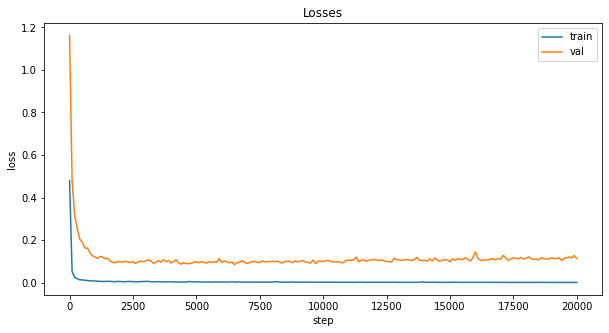

In [16]:
# Chart losses
losses = pd.DataFrame(all_losses)
losses['step'] = losses.index * eval_interval
print(losses)
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='step', y='train', data=losses, ax=ax, label='train')
sns.lineplot(x='step', y='val', data=losses, ax=ax, label='val')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax.set_title('Losses')
plt.show()

In [17]:

X, Y = get_batch("val")
print(X[0], Y[0])
logits, loss, targets = model(X, Y)
logits, loss

tensor([ 0.0083,  0.0156,  0.0988,  0.3744,  0.3729,  0.3136,  0.6441,  0.4723,
         0.3482,  0.4782,  0.5044,  0.3012,  0.3496,  0.3032,  0.5183,  0.6169,
         0.6217,  0.4794,  0.3848,  0.6202,  0.7107,  0.7677,  0.6916,  0.4780,
         0.4337,  0.4357,  0.3205,  0.6140,  0.6371,  0.6404,  0.3105,  0.1285,
         0.0000,  0.0389,  0.1951,  0.0630,  0.0722,  0.1404,  0.0085,  0.1637,
         0.2003,  0.2182,  0.3785,  0.1695,  0.3798,  0.3769,  0.3946,  0.4305,
         0.5376,  0.5376,  0.5343,  0.3213,  0.2194,  0.2901,  0.3640,  0.4168,
         0.8157,  0.7558,  0.6664,  0.5944,  0.7067,  0.8193,  0.9099,  0.9006,
         0.8681,  0.9798,  0.9052,  0.9507,  1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000], device='cuda:0') tensor([ 0.0156,  0.0988,  0.3744,  0.3729,  0.3136,  0.6441,  0.4723,  0.34

(tensor([ 0.0660,  0.1510,  0.2294,  ..., -0.5818, -0.4550, -0.3450],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor(0.1062, device='cuda:0', grad_fn=<MseLossBackward0>))

In [18]:
logits.isnan().sum(), logits.shape

(tensor(0, device='cuda:0'), torch.Size([1440]))

In [19]:
# Save the model
torch.save(model, model_fp)